<a href="https://colab.research.google.com/github/inders/AISenseiCommunity-Knowledge/blob/main/Transfomers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
''' Reference - https://github.com/inders/AISenseiCommunity-Knowledge/blob/main/TheIntutionOfTransfomersExplainedVisually.pdf
To understand the visual intuition behind transfomers in a simple way.
''''
# prompt: impor torch and numpy and nn from torch
import torch
import numpy as np
from torch import nn


In [3]:
# prompt: Generate numpy code to generate a 3d tensor of size 6*4*64 and print it

import numpy as np

# Generate a 3d tensor of size 6*4*64
tensor = np.random.rand(6, 4, 64)

# Print the tensor
print("Tensor shape", tensor.shape)
print(tensor)


Tensor shape (6, 4, 64)
[[[0.54086012 0.15824775 0.60683375 ... 0.61134126 0.54511702 0.81784567]
  [0.05213694 0.62883252 0.42539693 ... 0.03925798 0.3993763  0.20932885]
  [0.83196572 0.69898254 0.43141476 ... 0.64781385 0.50128772 0.60723052]
  [0.06585156 0.77225133 0.08960707 ... 0.96132807 0.79429279 0.80540425]]

 [[0.22061648 0.76704358 0.57378433 ... 0.26106238 0.46833753 0.29515404]
  [0.07520509 0.56829544 0.4601526  ... 0.45440702 0.32977951 0.12818874]
  [0.13803953 0.23477392 0.21297808 ... 0.99645422 0.59208742 0.02199065]
  [0.73800039 0.60607142 0.24570496 ... 0.56074535 0.75954825 0.70131236]]

 [[0.40949511 0.11722518 0.62719447 ... 0.58386977 0.90903385 0.52781523]
  [0.58179789 0.44678978 0.78427747 ... 0.13367623 0.91572512 0.50283794]
  [0.74283552 0.38035282 0.18718824 ... 0.61668143 0.59867648 0.36091518]
  [0.05727396 0.91258696 0.00998742 ... 0.07586451 0.6975711  0.95212615]]

 [[0.24577308 0.42574955 0.91809586 ... 0.26563318 0.04738325 0.83124057]
  [0.702

In [4]:
# prompt: split this tensor axis into 2 parts on axis=-1

# Split the tensor into two parts along the last axis
X1, X2 = np.split(tensor, 2, axis=-1)

#print original shape
print('X shape', tensor.shape)
#print(tensor)

# Print the first part
print('*******')
print('X1 shape', X1.shape)
#print(X1)


# Print the second part
print('*******')
print('X2 shape', X2.shape)
#print(X2)


X shape (6, 4, 64)
*******
X1 shape (6, 4, 32)
*******
X2 shape (6, 4, 32)


In [5]:
# prompt: generate code to learn about swapaxis function of numpy on the same input tensor

# Use the swapaxes function to swap the first and last axes of the tensor
swapped_tensor = np.swapaxes(tensor, -1, -2)

# Print the swapped tensor
print('Original tensor shape', tensor.shape)
print('Swapped Tensor shape after swapping the last two axis', swapped_tensor.shape)
#print(swapped_tensor)

Original tensor shape (6, 4, 64)
Swapped Tensor shape after swapping the last two axis (6, 64, 4)


In [15]:
# prompt: generate a function to check an input array is numpy array or not

def is_numpy_array(input_array):
  return isinstance(input_array, np.ndarray)


In [6]:
"""
To impelement attention as referenced and explained in my memo
here - https://www.linkedin.com/pulse/intuition-nuts-bolts-transformers-explained-visually-inder-singh-aarge/?trackingId=KjnvXjXdR4isgE2ZqkwNRg%3D%3D
we need to implement the following steps -

y = softmax (1/SQRT(d) (K @ Q^T)) @ V
K = x @ Wk
Q = x @ Wq
V = x @ Wv

Let's define the following defintions which will be used
B = batch size
T = number of sequences
D = number of dimensions for a single token/word
"""

'\nTo impelement attention as referenced and explained in my memo \nhere - https://www.linkedin.com/pulse/intuition-nuts-bolts-transformers-explained-visually-inder-singh-aarge/?trackingId=KjnvXjXdR4isgE2ZqkwNRg%3D%3D\nwe need to implement the following steps -\n\ny = softmax (1/SQRT(d) (K @ Q^T)) @ V\nK = x @ Wk\nQ = x @ Wq\nV = x @ Wv\n'

In [7]:
"""
 prompt: generate a function to generate softmax in numpy
 args:
   X : tensor of any shape

returns:
    softmax(X)
 """
def softmax(x):
  """
   Compute softmax values for each sets of scores in x.
   Why do we use axis=-1?
   We want to calculate softmax for each tensor and tensors are represented as columns.
   The last dimension of the tensor irrespective if it's of shape B,T, D or T, D represents
   the number of dimensions in the tensor. -1 in numpy represents the last dimension of tensor.
   keepdims=True will retain the tensor shape even if it returns a 1d arrary from a
   2d array by making the first dimension the channel
  """

  tensorColumnDimension = -1
  print("Inside softmax: x is numparray", is_numpy_array(x))
  e_x = np.exp(x - x.max(axis=tensorColumnDimension, keepdims=True))
  return e_x / e_x.sum(axis=tensorColumnDimension, keepdims=True)


In [8]:
"""
Implement attention
We want to implement Q, K, V which are three matrix multiplications.
Instead of doing three seperate matrix multiplications, we can do them in one shot to achieve parallelism
offered by GPU's. [K Q V] can be a matrix of BxTxD(it has three channels for K, Q, V)
and each channel has a TxD matrix.
As an example, if K, Q, V are matrices of dimensions 3xTx64 then
[Wk Wq Wv] can reperesented as one matrix of 3x512x64 where 512 represents the number of dimensions in
the feed forward layer.
It has three channels for Wk, Wq, Wv and each channel has 512*64 matrix which is the weight matrix
"""

def attention(X, mask, W_KQV, W_Out):
  """
  1. mulitply X with Wk, Wq, Wv and split it into three matrices

  Note - Why does the following code work for both batched and non-batched cases?
  In non-batched case X = [sequence length, num_dimensions_per_word] or [T, D]
  Let's sat X = [4, 6] and let's say W_QKV = [6, 9] where 3 columns represent each Q, K and V matrices
  After multiplication, we will get [4, 9] and splitting that into three parts on last dimension will
  give us three [4, 3] tensors for K, Q and V

  For a batched example
  X = [batch_size, sequence_length, num_dimensions_per_word] or [B, T, D]
  eg: Let's say X = [5, 4, 6] and  W_QKV = [6, 9] where 3 columns represent each Q, K and V matrices
  After the multiplication the resulting tensor will be [5, 4, 9] and splitting it on last dimension
  will give three matrices of [5, 4, 3].
  Each of these three matrices will have 5 batches of 4 sequence length, each with dimension_size of
  3 and represent the K, Q, V matrices
  """

  print("Inside attention: X shape=", X.shape)
  print("Inside attention: W_KQV shape=", W_KQV.shape)

  K, Q, V = np.split(X @ W_KQV, 3, axis=-1)

  print("Inside attention: K shape=", K.shape)
  print("Inside attention: Q shape=", Q.shape)
  print("Inside attention: V shape=", V.shape)
  print("Inside attention: mask shape=", mask.shape)

  """
  x.shape[-1] will give the number of columns in the tensor that is txd where T is sequence length and d
  is the number of dimensions in the vector

  Why do we normalize the attention matrix KxQ^T by the square root of d below?
  See the memo - https://www.linkedin.com/pulse/intuition-nuts-bolts-transformers-explained-visually-inder-singh-aarge/?trackingId=KjnvXjXdR4isgE2ZqkwNRg%3D%3D

  why normalizing on X.shape(-1) works for both batched and non-batched use-cases?
  As an example X can be [5, 9] or [T, d] for non-batch case.
  In this case D=9
  # When X is batched like [B, t, d] or [ 4, 5, 9]
  then also normalising on last dimension which is of D=9
  """

  print("Inside attention:X.shape[-1]=", X.shape[-1])
  norm_dim = np.sqrt(X.shape[-1])

  """
  How to do K @ Q^T so that it always works?
  - Replace last two axis to do transpose on batch and non-batch matrices.

  Why add mask after normalising?
  - Read memo

  What should be the sape of the attention matrix?
  Q = B, T, D
  K.T(transpose) = B, D, T
  atention matrix shape = B, T, T or T, T for non batched case
  """
  attn_matrix = K @ Q.swapaxes(-1, -2) /norm_dim + mask
  print("Inside attention: attn_matrix shape=", attn_matrix.shape)

  """
  Why calculate softmax over attention matrix?
  - softmax converts things into probability, and we need that to multiply by v. Read memo for more details
  """
  attn = softmax(attn_matrix)

  """
  In many implementations, this result is then passed through another linear transformation
  using W_out to obtain the final output of the self-attention layer.
  This step allows the network to potentially learn a more complex transformation of the
  attention-weighted values.
  """
  Y = attn @ V @ W_Out

  return Y, attn






In [10]:
"""
   Let's learn about the triu function which is used to create a matrix that is zero in lower diagonals
   We will use this to create the mask matrix later
"""

import torch
tensor = torch.randn(3, 3)
print('Random Tensor', tensor)

print('Upper triangular matrix with diagonal')
print(torch.triu(tensor, diagonal=0))

print('Upper triangular matrix without diagonal')
print(torch.triu(tensor, diagonal=1))

Random Tensor tensor([[ 0.5244,  0.6939,  2.0766],
        [ 0.1208,  0.5139,  0.7060],
        [-0.0182,  0.4172,  0.6065]])
Upper triangular matrix with diagonal
tensor([[0.5244, 0.6939, 2.0766],
        [0.0000, 0.5139, 0.7060],
        [0.0000, 0.0000, 0.6065]])
Upper triangular matrix without diagonal
tensor([[0.0000, 0.6939, 2.0766],
        [0.0000, 0.0000, 0.7060],
        [0.0000, 0.0000, 0.0000]])


In [11]:
# Parameters
embed_dim = 512  # Embedding dimension or D
num_heads = 1   # Number of heads, set to 1 for single-head attention
seq_len = 10    # Sequence length or T
batch_size = 4  # Batch size

"""
Attention matrix is [seq_len, seq_len] or [T, T] so we need create mask of the same dimensions
with negative infinity in upper diagonal part of matrix and zeros in lower diagonal part of matrix
"""
mask = torch.triu(-float("inf") * torch.ones(seq_len, seq_len), diagonal=1).detach()
print("mask shape=", mask.shape)


mask shape= torch.Size([10, 10])


In [12]:
import torch
import torch.nn as nn


"""
Let's calculate ground truth to compare our attention impelementation against
We will use the pytorch multihead attention implementation api for this
"""
multihead_attn = nn.MultiheadAttention(embed_dim=embed_dim, num_heads=num_heads)

"""
Example input data (query, key, value)
Note: PyTorch's MultiheadAttention expects input in the shape of [seq_len, batch_size, embed_dim]
or [T, B, D]
query = torch.rand(seq_len, batch_size, embed_dim) or [T, B, D]
key = torch.rand(seq_len, batch_size, embed_dim) or [T, B, D]
value = torch.rand(seq_len, batch_size, embed_dim) or [T, B, D]
"""
X = torch.rand(seq_len, batch_size, embed_dim)

"""
Apply the attention mechanism.
 attn_output: the output of the attention mechanism
 attn_output_weights: the weights of the attention mechanism after multiplying to V

In PyTorch, when using the MultiheadAttention module to calculate multi-head attention,
you can pass the same tensor as the query (Q), key (K), and value (V) as inputs. if you want
the module to compute Q, K, and V from the same source data.
"""
print("MultiHeadAttention X shape=", X.shape)
attn_output, attn_output_weights = multihead_attn(query=X, key=X, value=X, attn_mask=mask)

print("Attention Output Shape:", attn_output.shape)
print("Attention Weights Shape:", attn_output_weights.shape)





MultiHeadAttention X shape= torch.Size([10, 4, 512])
Attention Output Shape: torch.Size([10, 4, 512])
Attention Weights Shape: torch.Size([4, 10, 10])


In [13]:
"""

Let's compute actual attention using our numpy based attention on the same X, Q, K and V
and then compare if the output matrices are identical

Reshape X from seq_len, batch_size, embed_dim or T, B, D to batch_size, seq_len, batch_size or B, T, D
for our numpy impelmentation as that's the shape it takes the input tensor in.
"""
print("X shape", X.shape)
x_numpy = X.permute(1, 0, 2).detach().numpy()

"""
Let's use the weights from multi-head attention we calculated from pytorch to calculate our attention so
that we can compare if our matrix multiplication based attention is done right
"""
W_KQV_numpy = multihead_attn.in_proj_weight.detach().numpy()
W_out_numpy = multihead_attn.out_proj.weight.detach().numpy()

print("X_numpy shape", x_numpy.shape)
print("Mask shape", mask.shape)
print("W_KQKV shape", W_KQV_numpy.shape)
print("W_out shape", W_out_numpy.shape)



X shape torch.Size([10, 4, 512])
X_numpy shape (4, 10, 512)
Mask shape torch.Size([10, 10])
W_KQKV shape (1536, 512)
W_out shape (512, 512)


In [16]:
#reshape WQKV so that it can be multiplied by X inside the function
W_KQV_t = W_KQV_numpy.transpose()
W_out_t = W_out_numpy.transpose()
print("W_KQV reshaped size=",W_KQV_t.shape)
print("W_out reshaped size=", W_out_t.shape)

mask_numpy = mask.numpy()

Y, A = attention(x_numpy, mask_numpy, W_KQV_t, W_out_t)

print("numpy attention output shape=", Y.shape)
print("numpy attention weights output shape=", A.shape)
print("Attention Output Shape:", attn_output.shape)
print("Attention Weights Shape:", attn_output_weights.shape)


W_KQV reshaped size= (512, 1536)
W_out reshaped size= (512, 512)
Inside attention: X shape= (4, 10, 512)
Inside attention: W_KQV shape= (512, 1536)
Inside attention: K shape= (4, 10, 512)
Inside attention: Q shape= (4, 10, 512)
Inside attention: V shape= (4, 10, 512)
Inside attention: mask shape= (10, 10)
Inside attention:X.shape[-1]= 512
Inside attention: attn_matrix shape= (4, 10, 10)
Inside softmax: x is numparray True
numpy attention output shape= (4, 10, 512)
numpy attention weights output shape= (4, 10, 10)
Attention Output Shape: torch.Size([10, 4, 512])
Attention Weights Shape: torch.Size([4, 10, 10])


In [17]:
"""
Let's reshape attn_output_shape (pytorch multi head attention) from
[seq_len, batch_size, embed_dim] to [batch_size, seq_len, embed_dim]
i.e. T, B, D to B, T, D
"""

multihead_attn_output_numpy = attn_output.permute(1, 0, 2).detach().numpy()
print("multihead_attn_output_numpy shape=", multihead_attn_output_numpy.shape)

"""
Let's compute the difference between the output of pytorch and out numpy attention blocks.
The smaller difference proves that our implementation is correct
"""
print("Difference in attention output=", np.linalg.norm(Y - multihead_attn_output_numpy))
print("Difference in attention matrix=", np.linalg.norm(A - attn_output_weights.detach().numpy()))

multihead_attn_output_numpy shape= (4, 10, 512)
Difference in attention output= 1.245342e-05
Difference in attention matrix= 2.8223837e-07


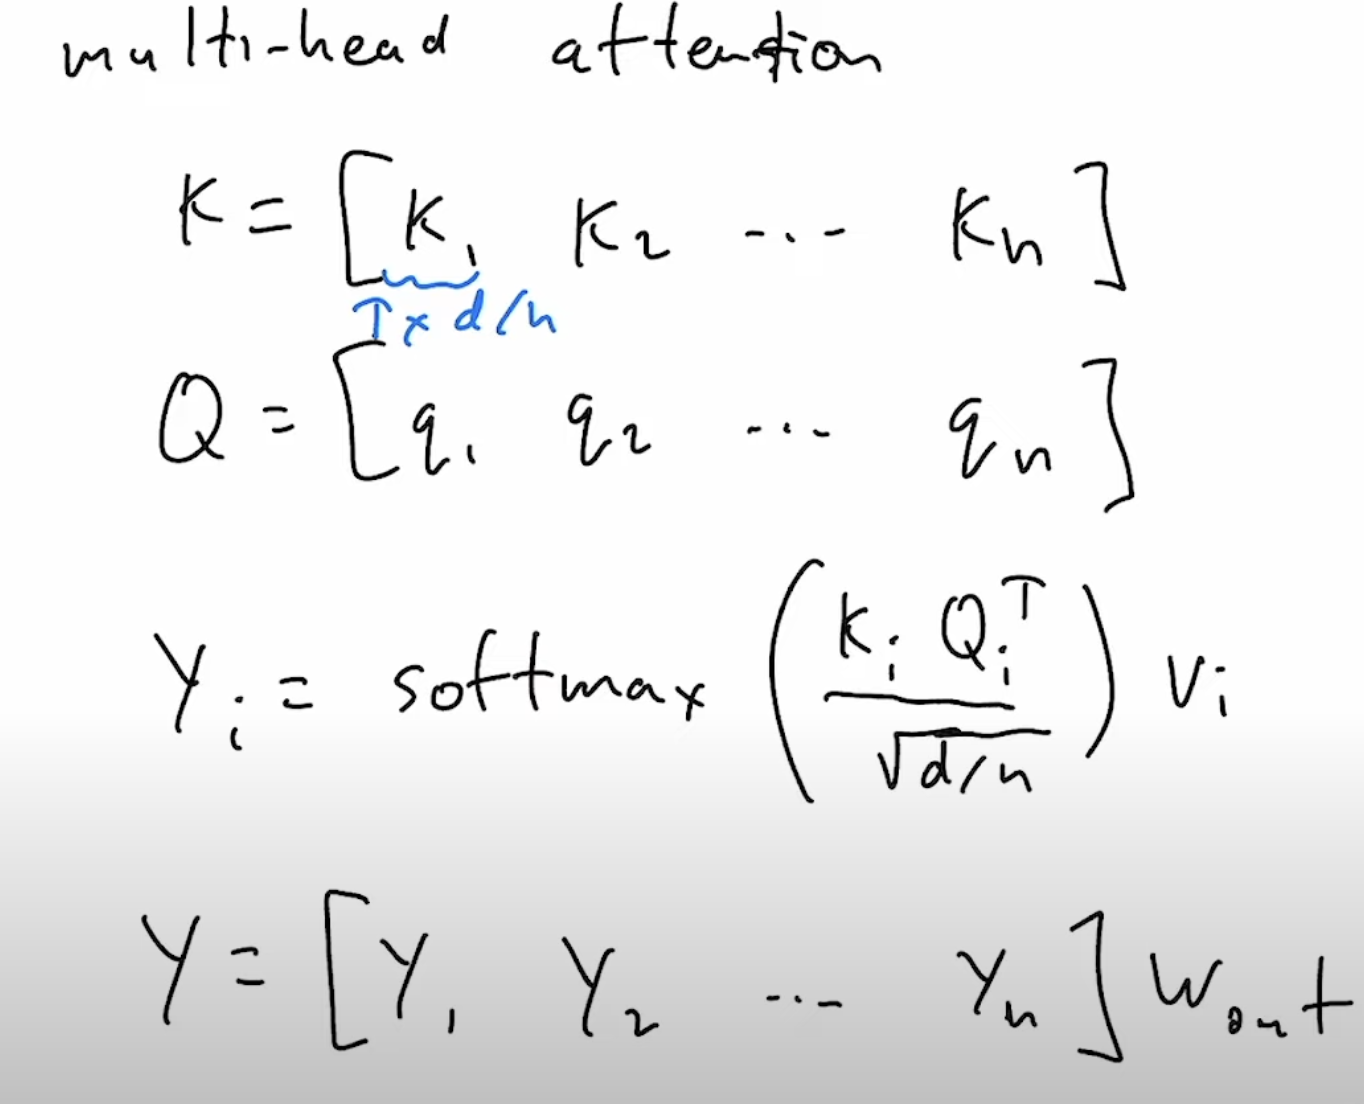

In [18]:
"""
Let's implement multi-head attention
1. As shown in the picture below and in the original memo multihead attention is impelmented by having
different K,Q and V matrices for each head.
2. Calculating attention for each head seperately and projecting on V
3. Concatenating them together as shown in the picture above

To implement this, K, Q and V will become from Txd(embed_dim) matrix to Txdxh
where h represents the number of heads.
The vectors of all heads of K, Q, V are concatenated together to achieve Txdxh matrix
To do this in batches we have to convert this into BxHxTxD
so that we have all heads of a single batch together and within each head their TxD matrices
"""

def numpy_multi_head_attention(X, W_KQV, mask, num_heads, W_out):
  B, T, d = X.shape
  #Split W_KQV into K, Q, V
  K, Q, V = np.split(X @ W_KQV, 3, axis=-1)

  # we have to convert K, Q, V from BxTxD to BxHxTxd
  head_axis = 2
  d_axis = 1

  """
  The multiple heads of K, Q, V are contained as a large matrix such that all heads of K
  are in the vector of K and so on for Q and V.
  This is why when we divide K, Q, V by num_heads, we will get a shape of BxTxnum_headsxd
  and swapping axis 1 and 2 i.e. head_axis with d_axis will give us the needed shape --
  Bxnum_headsxTxd
  """
  K = K.reshape(B, T, num_heads, d // num_heads).swapaxes(d_axis, head_axis)
  Q = Q.reshape(B, T, num_heads, d // num_heads).swapaxes(d_axis, head_axis)
  V = V.reshape(B, T, num_heads, d // num_heads).swapaxes(d_axis, head_axis)

  """
  Let's calculate attention
  Single head attention code was
  attn_matrix = K @ Q.swapaxes(-1, -2) /norm_dim + mask

  Remember that K, Q, V are Bxnum_headsxTxD so for doing transpose of Q below we swap the last two axis
  K shape is B, h, T, D and Q after transpose is B, h, D, T
  resulting in an output attention matrix of B, H, T, T

  Why do we divide d by num_heads to normalise?
  d is combined shape of all heads initially stacked up K, Q, V as shown in first line of this function
  we need to divide it by num_heads to get real D(embed_dim) for each head
  """
  scaled_dot_product  = K @ Q.swapaxes(-1, -2) // np.sqrt(d // num_heads)

  print("Inside numpy_multi_head_attention BATCH mode: scaled_dot_product shape, is NumpyArray ",
        scaled_dot_product.shape, is_numpy_array(scaled_dot_product))
  print("Inside numpy_multi_head_attention BATCH mode: mask shape, isNumPyArray ", mask.shape,
        is_numpy_array(mask))

  attn = scaled_dot_product + mask
  attn_matrix = softmax(attn)

  """
  attn_matrix is of shape Bxnum_headsxTxT produced by multiplying Bxnum_headsxTxd into Bxnum_headsxdXT
  V matrix is of shape Bxnum_headsxTxd
  attn @ V should be Bxnum_headsxTxd
  We want it to convert it back to BxTxnum_headsXd as that's the K, Q, V we got after splitting
  before getting to B, T, D
  (inversing what we did to get K, Q, V -- see above in this function)
  We achieve this through swapaxes and then reshape below
  """
  Y = (attn_matrix @ V).swapaxes(1, 2).reshape(B, T, d) @ W_out
  return Y, attn_matrix








In [17]:
#Let's test multi-head attention by changing num_heads to 4
#Let's find our ground truth using pytorch multihead attention
num_heads = 4
batch_multihead_attn = nn.MultiheadAttention(embed_dim=embed_dim, num_heads=num_heads,
                                             bias=False, batch_first=True)
print("BATCH MultiHeadAttention X shape=", X.shape)
print("X should not be a numpy array = ",is_numpy_array(X))

#Reshape X from seq_len, batch_size, embed_dim to batch_size, seq_len, embed_dim when batch_first=True
X = X.permute(1, 0, 2)
print("BATCH MultiHeadAttention X shape=", X.shape)

Y_, A_ = batch_multihead_attn(query=X, key=X, value=X, attn_mask=mask)

print("Attention Output Shape:", Y_.shape)
print("Attention Weights Shape:", A_.shape)



BATCH MultiHeadAttention X shape= torch.Size([10, 4, 512])
X should not be a numpy array =  False
BATCH MultiHeadAttention X shape= torch.Size([4, 10, 512])
Attention Output Shape: torch.Size([4, 10, 512])
Attention Weights Shape: torch.Size([4, 10, 10])


In [18]:
#Let's calculate actuals using out NUMPY implementation
#reshape X from seq_len, batch_size, embed_dim to batch_size_seq_len, batch_size for our numpy impelmentation
print("X shape", X.shape)
x_numpy = X.detach().numpy()
W_KQV_numpy = batch_multihead_attn.in_proj_weight.detach().numpy()
W_out_numpy = batch_multihead_attn.out_proj.weight.detach().numpy()

print("X_numpy shape", x_numpy.shape)
print("Mask shape", mask.shape)
print("W_KQKV shape", W_KQV_numpy.shape)
print("W_out shape", W_out_numpy.shape)

#reshape WQKV so that it can be multiplied by X inside the function
W_KQV_t = W_KQV_numpy.transpose()
W_out_t = W_out_numpy.transpose()
print("W_KQV reshaped size=",W_KQV_t.shape)
print("W_out reshaped size=", W_out_t.shape)
mask_numpy = mask.numpy()



X shape torch.Size([4, 10, 512])
X_numpy shape (4, 10, 512)
Mask shape torch.Size([10, 10])
W_KQKV shape (1536, 512)
W_out shape (512, 512)
W_KQV reshaped size= (512, 1536)
W_out reshaped size= (512, 512)


In [19]:
Y_numpy, A_numpy = numpy_multi_head_attention(X=x_numpy, W_KQV=W_KQV_t, mask=mask_numpy, W_out=W_out_t, num_heads=num_heads)

print("numpy_multi_head_attention Y shape =", Y_numpy.shape)
print("numpy_multi_head_attention A shape =", A_numpy.shape)


Inside numpy_multi_head_attention BATCH mode: scaled_dot_product shape, is NumpyArray  (4, 4, 10, 10) True
Inside numpy_multi_head_attention BATCH mode: mask shape, isNumPyArray  (10, 10) True
Inside softmax: x is numparray True
numpy_multi_head_attention Y shape = (4, 10, 512)
numpy_multi_head_attention A shape = (4, 4, 10, 10)


In [20]:
#let's see the difference for batched multi-head-attention between ground truth and reality
#Let's reshape attn_output_shape from [seq_len, batch_size, embed_dim] to [batch_size, seq_len, embed_dim]
#Let's compute the difference between the output of pytorch and out numpy attention blocks

print("Y_ shape =", Y_.shape)
print("Y_numpy shape = ", Y_numpy.shape)
print("Difference in attention weights output=", np.linalg.norm(Y_numpy - Y_.detach().numpy()))
print("Difference in attention matrix=", np.linalg.norm(A_numpy - A_.detach().numpy()))

Y_ shape = torch.Size([4, 10, 512])
Y_numpy shape =  (4, 10, 512)
Difference in attention weights output= 1.7430538
Difference in attention matrix= 1.5289094




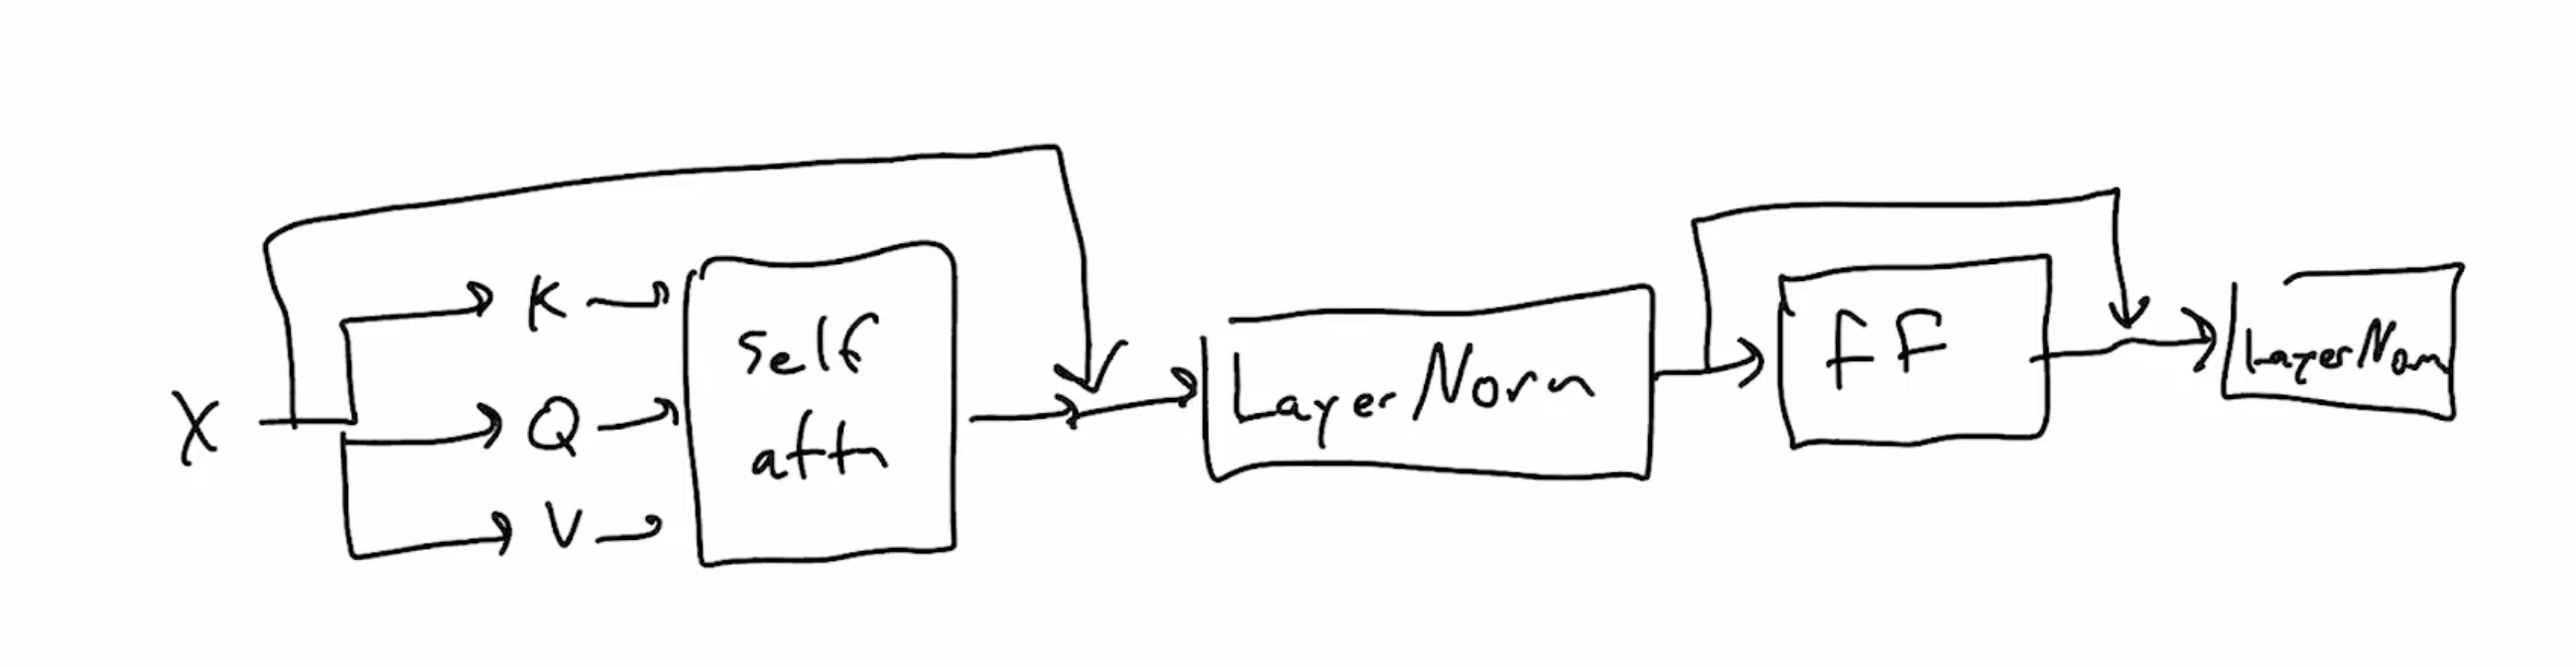



In [ ]:
#The above diagram depicts how we can code a transfomer block using self-attention


In [25]:
#Let's define LayerNorm
#Layer normalization is a technique used in neural networks to stabilize the learning process.
#It was introduced to address some of the issues associated with training deep networks,
#such as internal covariate shift, where the distribution of each layer's inputs changes during training,
#making the training process slow and less stable. Layer normalization helps by normalizing the inputs
#across the features for each training example.

#Inputs could be B, T, d
#Remember features/tensors are column vectors
#calculating mean, var on -1 below is working on the last column which is the feature vector across
#batches for all T's(sequences)
def layer_norm(Z, eps):
  mean = Z.mean(axis=-1, keepdims=True)
  std = np.sqrt(Z.var(axis=-1, keepdims=True) + eps)
  return (Z - mean)/std





In [27]:
def relu(inputs):
  """
  Performs the ReLU activation function on the input.

  Args:
    inputs: A numpy array or PyTorch tensor.

  Returns:
    The ReLU-activated input.
  """

  # Use numpy.maximum() for numpy arrays.
  if isinstance(inputs, np.ndarray):
    return np.maximum(0, inputs)

  # Use torch.relu() for PyTorch tensors.
  elif isinstance(inputs, torch.Tensor):
    return torch.relu(inputs)

  # Raise an error if the input type is not supported.
  else:
    raise TypeError("Unsupported input type: {}".format(type(inputs)))

In [41]:

def transfomer_numpy(X, W_KQV_numpy_t, mask_numpy, W_out_numpy_t, num_heads, W_ff1, W_ff2, eps):
  """
    Performs the transformer block as outlined in the diagram using
      1. MultiHeadAttention
      2. Relu
      3. LayerNorm
      4. FeedForward Network

      Args:
        X: B, T, D
        mask: T, T
        heads: number of heads
        W_KQV_t: B, num_heads, T, D [_t represents tranposed matrix]
        W_Out_t: B, T, D [_t represents transposed matrix]
        W_ff1: weight of first feed forward layer
        W_ff2: weight of second feed forward layer
        eps: epislon for layer norm to smoothen graidents between layers
"""

  Y_, A_ = numpy_multi_head_attention(X=x_numpy, W_KQV=W_KQV_t, mask=mask_numpy, W_out=W_out_t, num_heads=num_heads)
  #Add Residual layer to Y_ to bring back X to forward layers, then normalize it
  Y_res = X + Y_
  Y_norm = layer_norm(Y_res, eps=eps)
  #Take residual through two layers of feed forward network
  Z = relu(Y_norm @ W_ff1) @ W_ff2
  #bring back Y_norm into Z through a residual layer
  Z_res = Z + Y_norm
  #normalize Z_res
  Z = layer_norm(Z_res, eps=eps)
  return Z


In [50]:
"""
Let's create ground truth to test our numpy based transfomer block against
"""
import torch.nn.init as init
trans = nn.TransformerEncoderLayer(embed_dim, num_heads, dim_feedforward=embed_dim, dropout=0.0, batch_first=True)
# Initialize the biases to zero
init.constant_(trans.linear1.bias, 0)
init.constant_(trans.linear2.bias, 0)
Y_ = trans(X, mask)
print(Y_.shape)

torch.Size([4, 10, 512])


In [51]:
"""
 Let's get the output from our numpy based transfomer block
"""

W_KQV_t = trans.self_attn.in_proj_weight.detach().numpy().T
W_out_t = trans.self_attn.out_proj.weight.detach().numpy().T
W_ff1 = trans.linear1.weight.detach().numpy()
W_ff2 = trans.linear2.weight.detach().numpy()
eps = trans.norm1.eps

Y = transfomer_numpy(X=X, W_KQV_numpy_t=W_KQV_t, W_out_numpy_t=W_out_t, mask_numpy=mask_numpy,
                     W_ff1=W_ff1, W_ff2=W_ff2, eps=eps, num_heads=num_heads)
print(Y.shape)

Inside numpy_multi_head_attention BATCH mode: scaled_dot_product shape, is NumpyArray  (4, 4, 10, 10) True
Inside numpy_multi_head_attention BATCH mode: mask shape, isNumPyArray  (10, 10) True
Inside softmax: x is numparray True
torch.Size([4, 10, 512])


In [53]:
#Let's compare ground truth to acutal for transfomer block
print(np.linalg.norm(Y.detach().numpy() - Y_.detach().numpy()))

44.82754
